### 笔记：
    1. sns.lmplot()

# 使用AdaBoost对科比投篮是否命中进行预测

AdaBoost（adaptive boosting,自适应提升算法）是集成方法（ensemble method）中最流行和最具代表性的一个版本，于1995年由Yoav Freund和Robert Shapire提出，它的想法是将多个弱学习算法进行组合形成一个强学习算法。对于分类问题而言，给定一个训练样本集，求比较粗糙的弱分类器要比求精确的强分类器容易的多，AdaBoost就是从弱分类器出发，反复学习，通过在学习过程中提高那些被前一轮弱分类器错误分类样本的权值，以及加大分类误差率小的弱分类器权值，最后进行加权多数表决，以此实现从弱分类器到强分类器的提升。

AdaBoost的优点在于其泛化错误率低，易编码，可以应用在大部分分类器上，无需参数调整。AdaBoost的缺点也较明显，它对异常值敏感。它适用于数值型（numeric）和名义型(nominal)数据的分析。

本案例的数据来源于著名数据建模和数据分析竞赛平台Kaggle上的一个名为”Kobe Brayant Shot Selection“的一个竞赛，该竞赛非常适合用于分类训练、特征工程和时间序列分析。

## 科比
科比·布莱恩特（Kobe Bryant），是NBA历史上一名伟大的球星，他17岁进入NBA，曾在一场比赛中拿到81分，他拥有五枚总冠军戒指，他于2016年4月14日正式退役。本案例需要分析科比在20年职业生涯中投中和投失球的各项数据，并根据他投球的位置和投球的方式等信息预测该球能否投中，这是一个典型的二分类问题。

我们首先使用sklearn工具进行AdaBoost实现，然后再从AdaBoost算法理论出发，自己动手定义函数实现AdaBoost,比较普通分类算法和AdaBoost算法之间预测效果的差异。

## 1. 数据源

在本案例中，我们使用的是1996年至2016年科比在NBA赛场上投篮的各项数据。我们首先导入之后会用到的包，然后看看这份数据里包含哪些变量：

In [3]:
import numpy as np # 线性代数
import pandas as pd # 数据处理及CSV文件的读写(例如 pd.read_csv)
import matplotlib.pyplot as plt # 常规画图
import seaborn as sns # 图形渲染好
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
# 使用内嵌模式画图
%matplotlib inline

In [8]:
kobe = pd.read_csv('./dataset/data.csv')
kobe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [9]:
kobe.head(10)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
6,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,0,2000-01,52,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,7
7,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,0,2000-01,5,2,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,8
8,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,0,2000-01,12,12,1.0,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,9
9,Running Jump Shot,Jump Shot,294,20000012,33.9193,-33,125,-118.3028,3,3,0,2000-01,36,12,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,10


数据集包含30697个样本，共有25个变量，其中有3个浮点型（float）变量、11个整型（Int）变量和11个对象型（object）变量,除了shot_made_flag变量外都不存在缺失值，目标标量为show_made_flag，每个变量对应的含义如下所示：

    变量名	说明	类型	示例
    action_type	细分投篮类型	object	Floating Jump Shot
    combined_shot_type	综合投篮类型，共六种：
    Jump Shot 跳投
    Layup 上篮
    Dunk 扣篮
    Tip Shot 补篮
    Hook Shot 勾手投篮
    Bank Shot 擦板投篮	object	Layup
    game_event_id	赛事ID	int64	318
    game_id	比赛ID	int64	21501228
    lat	投篮位置纬度	float64	34.0443
    loc_x	横向投篮位置（短边）  x 	int64	0
    loc_y	纵向投篮位置（长边） y 	int64	7
    lon	投篮位置经度	float64	-118.2698
    minutes_remaining	比赛剩余分钟数	int64	4
    period	比赛第几节	int64	3
    playoffs	季后赛标识
    0 常规赛
    1 季后赛	int64	1
    season	赛季	object	2005-2006
    seconds_remaining	比赛剩余秒数	int64	32
    shot_distance	投篮离篮筐的距离	int64	24
    shot_made_flag	命中标记
    0 未命中
    1 命中	float64	0
    shot_type	得分类型
    2PT Field Goal 2分球
    3PT Field Goal 3分球	object	2PT Field Goal
    shot_zone_area	投篮位置（区域划分）	object	Center(C)
    shot_zone_basic	投篮位置(基本)	object	Mid-Range
    shot_zone_range	投篮位置离框距离	object	15-24 ft
    team_id	所在队伍ID	int64	1610612747
    team_name	所在队伍名字	object	Los Angeles Lakers
    game_date	比赛日期	object	2016-04-13
    matchup	对阵形势	object	LAL @ SAS
    opponent	对手	object	SAS
    shot_id	投篮ID	int64	2047

## 2 数据探索和预处理

### 数据集初探

我们首先用“投篮ID”作为索引（index），然后利用head方法对数据集做一个简单的浏览（这里我们设置“显示列数不限”以浏览所有的列）：

In [10]:
kobe.set_index('shot_id',inplace=True)    # 用shot_id作为索引
pd.set_option('display.max_columns',None) # 设置无列显示上限 
kobe.head(4)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


head浏览方式不易看出整个数据集的特征，一个更好的办法是利用numpy中的permutation方法随机选取数据集中的几个样本进行浏览，为了显示方便，我们将列名放在竖直方向：

In [13]:
#np.random.permutation(5)   # 返回array([4, 2, 3, 0, 1])

In [11]:
random_sample = kobe.take(np.random.permutation(len(kobe))[:4])
random_sample.T

shot_id,25512,17293,23956,21794
action_type,Jump Shot,Turnaround Fadeaway shot,Jump Shot,Jump Shot
combined_shot_type,Jump Shot,Jump Shot,Jump Shot,Jump Shot
game_event_id,14,299,296,57
game_id,29900611,21000637,29700790,21500017
lat,33.8693,34.0373,33.9083,34.0653
loc_x,-119,114,-102,223
loc_y,175,7,136,-21
lon,-118.389,-118.156,-118.372,-118.047
minutes_remaining,10,5,4,6
period,1,3,3,1


接下来，我们对数据集进行描述性统计分析，按照不同的类别查看描述性统计信息：

### 投篮区域可视化

<Figure size 2160x21600 with 0 Axes>

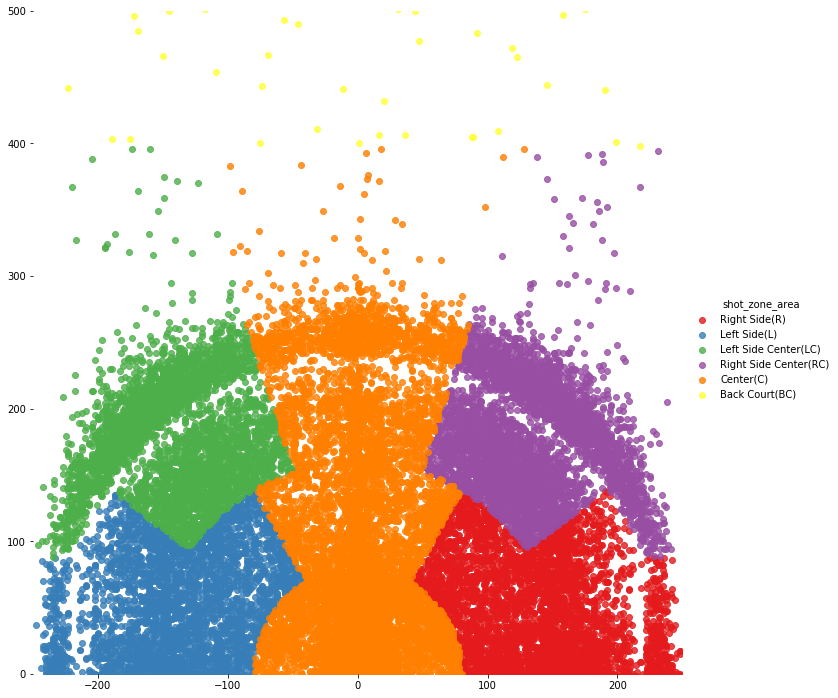

<Figure size 2160x21600 with 0 Axes>

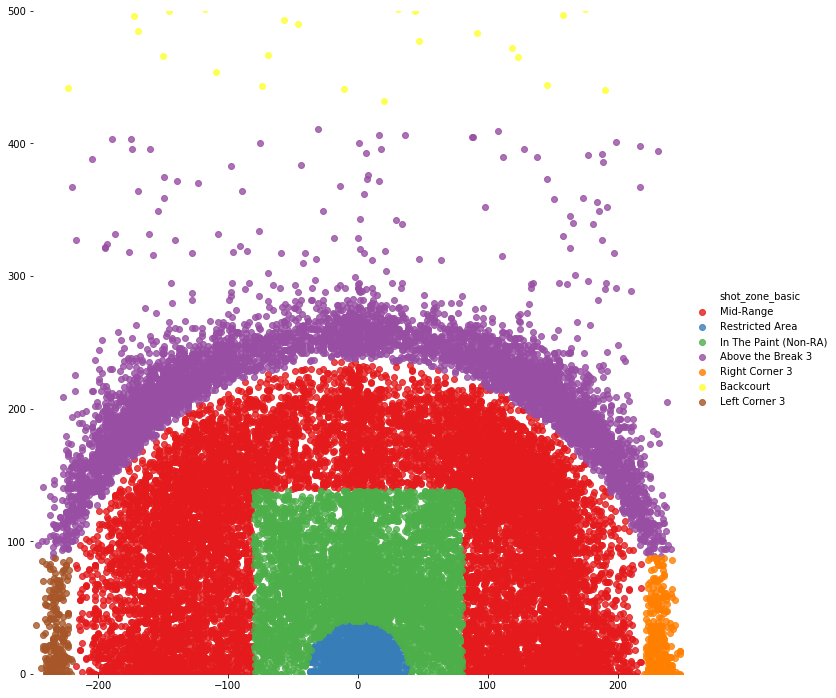

<Figure size 2160x21600 with 0 Axes>

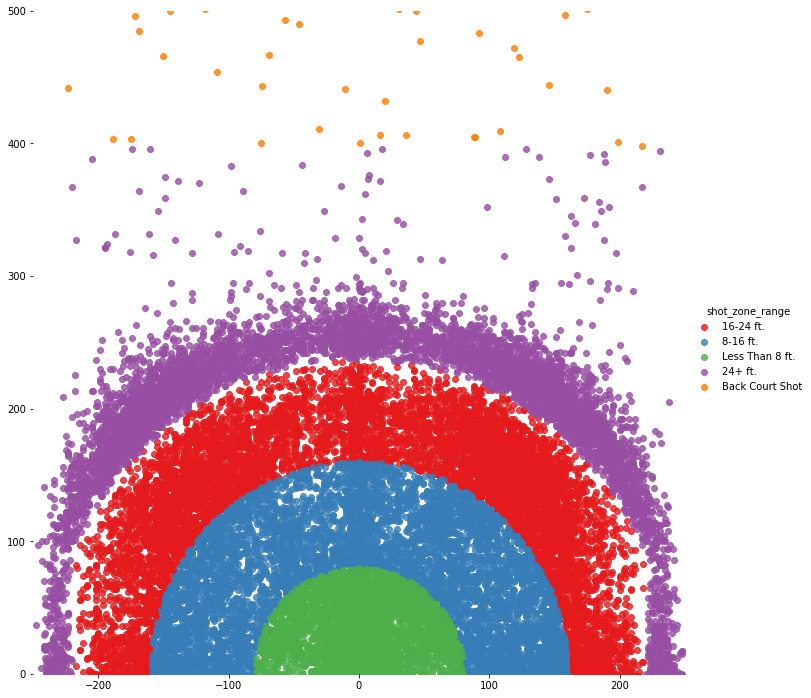

In [15]:
shot_zone = ['shot_zone_area', 'shot_zone_basic', 'shot_zone_range']
for zone in shot_zone:
    plt.figure(figsize=[30,300])
    sns.lmplot('loc_x','loc_y', 
               data=kobe, 
               hue=zone,
               fit_reg=False,
               palette="Set1",
               height=10,
              )
    plt.xlim([-250,250])
    plt.ylim([0,500])
    plt.xlabel('')
    plt.ylabel('')
    sns.despine(left=True,bottom=True)

### 描述性统计分析

为了后续更方便分析，我们先将一些变量转换成分类变量：

In [16]:
kobe['game_event_id'] = kobe['game_event_id'].astype('category')
kobe['game_id'] = kobe['game_id'].astype('category')
kobe['period'] = kobe['period'].astype('category')
kobe['playoffs'] = kobe['playoffs'].astype('category')
kobe['season'] = kobe['season'].astype('category')
kobe['shot_made_flag'] = kobe['shot_made_flag'].astype('category')
kobe['shot_type'] = kobe['shot_type'].astype('category')
kobe['team_id'] = kobe['team_id'].astype('category')

转换之后的变量情况：

In [17]:
kobe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 1 to 30697
Data columns (total 24 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null category
game_id               30697 non-null category
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null category
playoffs              30697 non-null category
season                30697 non-null category
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null category
shot_type             30697 non-null category
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null categor

In [18]:
# 数值型变量的描述性统计信息
kobe.describe(include=['number']).T

,count,mean,std,min,25%,50%,75%,max
lat,30697.0,33.953192,0.087791,33.2533,33.8843,33.9703,34.0403,34.0883
loc_x,30697.0,7.110499,110.124578,-250.0000,-68.0000,0.0000,95.0000,248.0000
loc_y,30697.0,91.107535,87.791361,-44.0000,4.0000,74.0000,160.0000,791.0000
lon,30697.0,-118.262690,0.110125,-118.5198,-118.3378,-118.2698,-118.1748,-118.0218
minutes_remaining,30697.0,4.885624,3.449897,0.0000,2.0000,5.0000,8.0000,11.0000
seconds_remaining,30697.0,28.365085,17.478949,0.0000,13.0000,28.0000,43.0000,59.0000
shot_distance,30697.0,13.437437,9.374189,0.0000,5.0000,15.0000,21.0000,79.0000


我们观察到shot_made_flag变量存在5000个缺失值，这是因为该数据集由于竞赛需要，主办方在数据集中选择了5000个样本作为测试集数据，需要参赛者对其进行预测，以此对参赛者进行评估。后面我们将扔掉这5000个样本，并在剩下的样本中划分训练集和测试集，以验证模型训练的效果。

In [19]:
# 名义型变量的描述性统计信息
kobe.describe(include=['object']).T

,count,unique,top,freq
action_type,30697,57,Jump Shot,18880
combined_shot_type,30697,6,Jump Shot,23485
shot_zone_area,30697,6,Center(C),13455
shot_zone_basic,30697,7,Mid-Range,12625
shot_zone_range,30697,5,Less Than 8 ft.,9398
team_name,30697,1,Los Angeles Lakers,30697
game_date,30697,1559,2016-04-13,50
matchup,30697,74,LAL @ SAS,1020
opponent,30697,33,SAS,1978


从上面的统计信息可以看得出，科比的投篮方式主要是跳投（Jump Shot），并且他在NBA的职业生涯里只效力过一支球队：洛杉矶湖人队（Los Angeles Lakers），伟大的湖人王朝正是在科比带领下建立起来的。

接下来，我们将检查数据集是否为不平衡数据集，以及对其做异常值检测。

### 不平衡分析和异常值检测

我们首先检查数据集的不平衡状况：

Text(0.5,1,'Target class distribution')

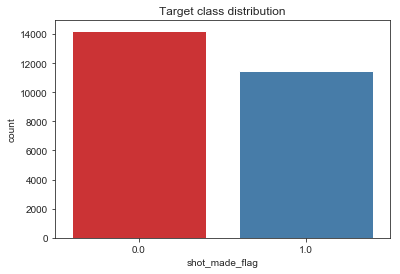

In [20]:
sns.set_style('ticks')       # 显示刻度，并取消网格
sns.set_palette('Set1')      # 配色使用Set1
ax = plt.axes() 
sns.countplot(x='shot_made_flag',
              data=kobe,
              ax=ax) 
ax.set_title('Target class distribution')

可以看到，目标变量的值分布比较均匀，不存在不平衡问题，无需进行不平衡处理。

然后我们利用盒图对数据集中的数值型变量进行异常值检测，盒图示意如下：

我们先提取出数据集中的数值型变量，然后对所有的数值型变量按不同的目标变量值画出其盒图，如下所示：

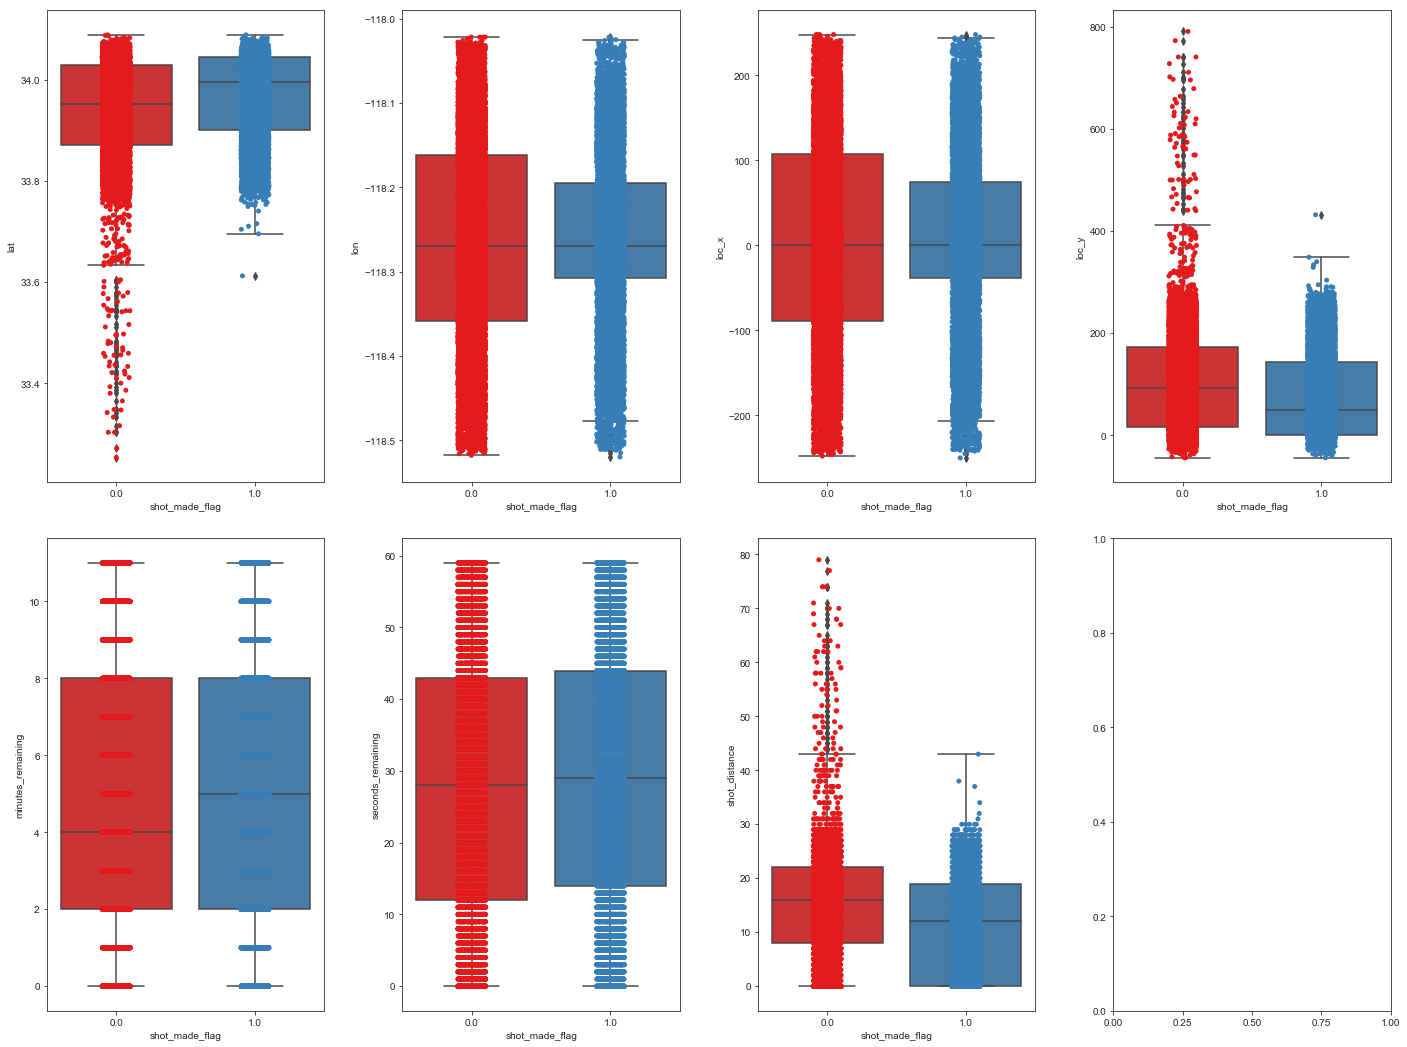

In [21]:
f,axarr = plt.subplots(2,4,figsize=(20,15))
sns.set_context("notebook", font_scale=1.8) # 放大横纵坐标标记，更容易看清
sns.stripplot(x='shot_made_flag',y='lat',data=kobe,jitter=True,ax=axarr[0,0])
sns.boxplot(x='shot_made_flag',y='lat',data=kobe,ax=axarr[0,0])
sns.stripplot(x='shot_made_flag',y='lon',data=kobe,jitter=True,ax=axarr[0,1])
sns.boxplot(x='shot_made_flag',y='lon',data=kobe,ax=axarr[0,1])
sns.stripplot(x='shot_made_flag',y='loc_x',data=kobe,jitter=True,ax=axarr[0,2])
sns.boxplot(x='shot_made_flag',y='loc_x',data=kobe,ax=axarr[0,2])
sns.stripplot(x='shot_made_flag',y='loc_y',data=kobe,jitter=True,ax=axarr[0,3])
sns.boxplot(x='shot_made_flag',y='loc_y',data=kobe,ax=axarr[0,3])
sns.stripplot(x='shot_made_flag',y='minutes_remaining',data=kobe,jitter=True,ax=axarr[1,0])
sns.boxplot(x='shot_made_flag',y='minutes_remaining',data=kobe,ax=axarr[1,0])
sns.stripplot(x='shot_made_flag',y='seconds_remaining',data=kobe,jitter=True,ax=axarr[1,1])
sns.boxplot(x='shot_made_flag',y='seconds_remaining',data=kobe,ax=axarr[1,1])
sns.stripplot(x='shot_made_flag',y='shot_distance',data=kobe,jitter=True,ax=axarr[1,2])
sns.boxplot(x='shot_made_flag',y='shot_distance',data=kobe,ax=axarr[1,2])
plt.tight_layout()

我们可以从盒图中看出，变量lat、loc_y以及shot_distance存在较多的异常值，但是这些异常值并不“异常”，比如对于loc_y和shot_distance的异常值，在很少的情形下（比如中场时间快到时，发球后直接在距离3分线较远的地方投篮），科比会选择直接投超远距离三分。 我们在之后的训练中会将这些异常值去除掉，并讨论去除异常值与不去除异常值对模型训练的影响。

    我们画出点对图来分析变量之间的相关关系： 

D:\Apps\PythonicApps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Apps\PythonicApps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Apps\PythonicApps\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; u

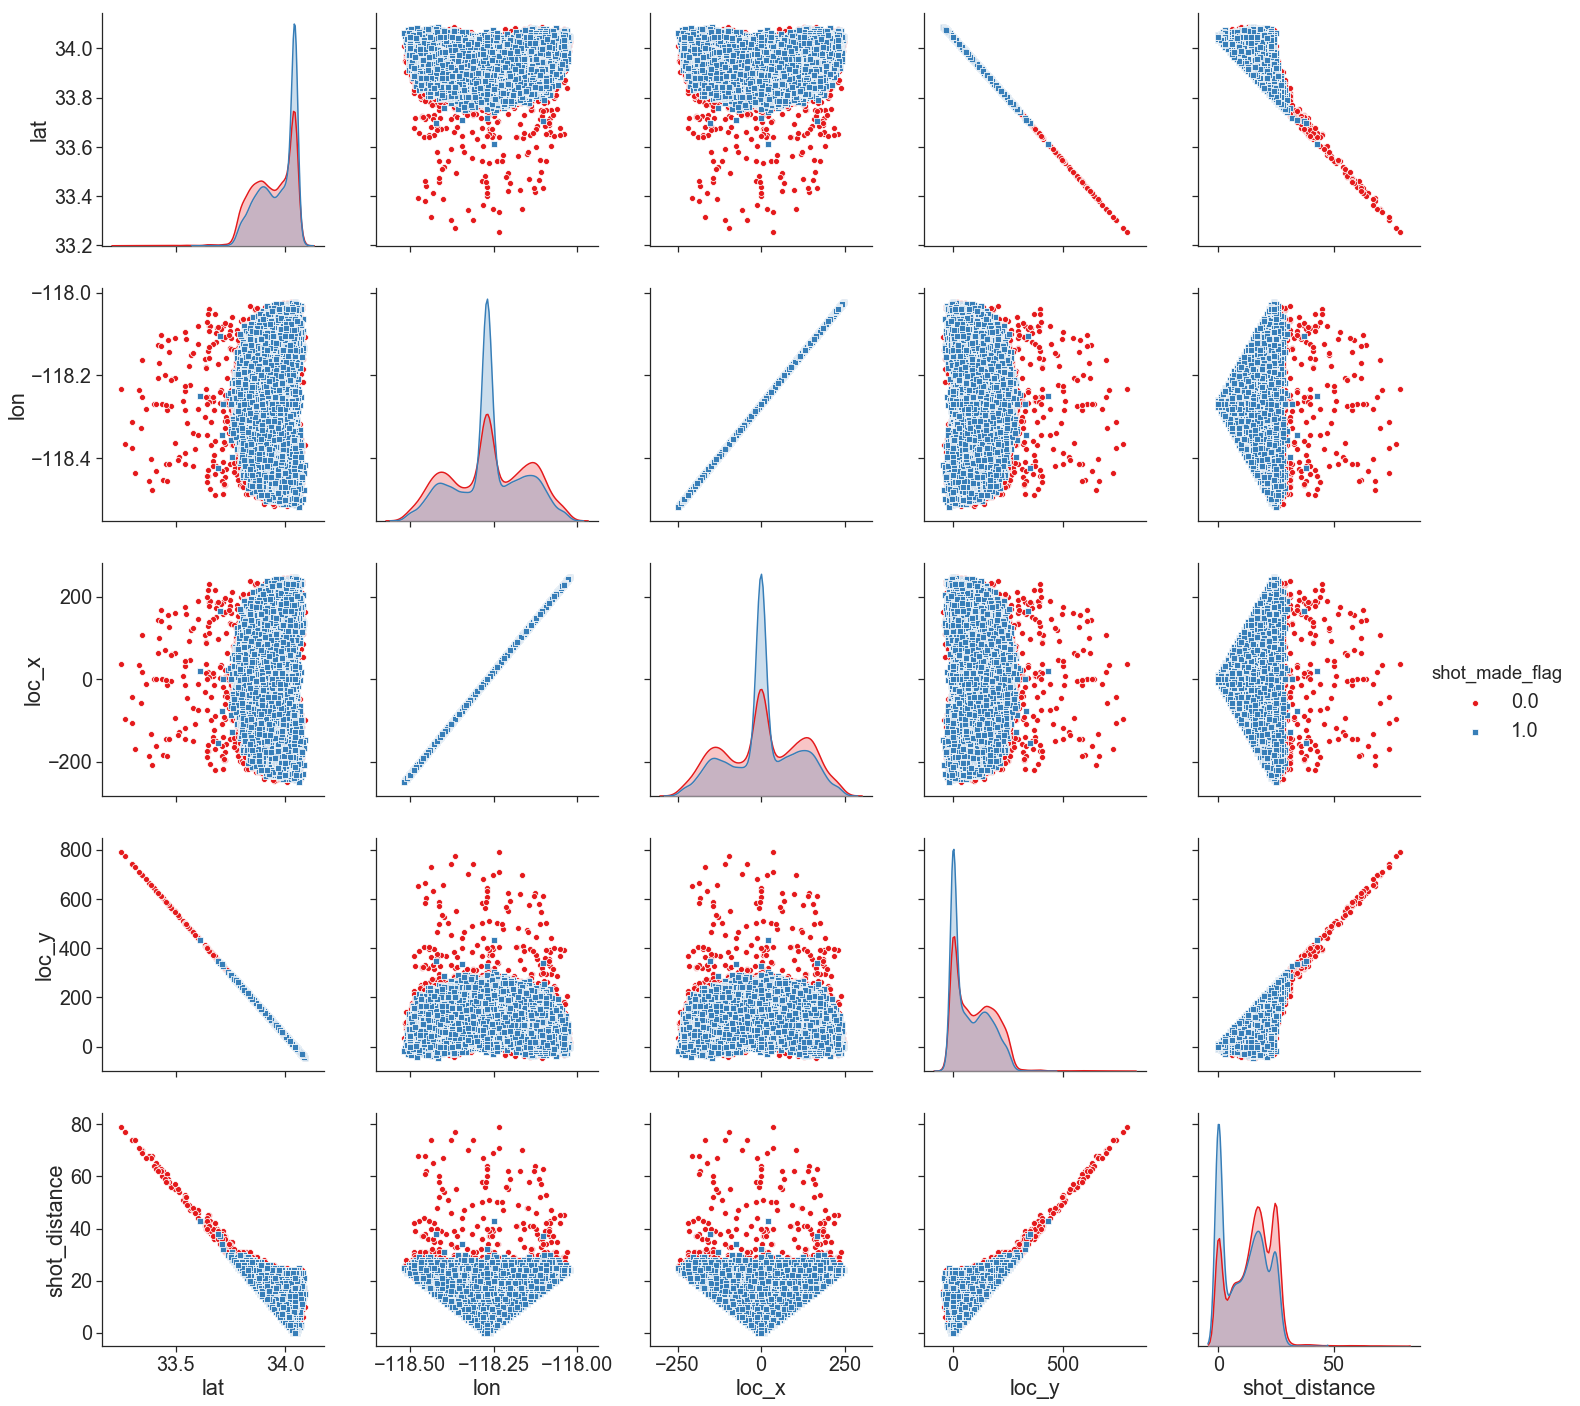

In [26]:
sns.pairplot(kobe,
             vars = ['lat','lon','loc_x','loc_y','shot_distance'],
             hue='shot_made_flag',
             markers=['o','s'],
             diag_kind='kde',
             diag_kws=dict(shade=True),
             height=4)

从点对图，我们可以看出lat与loc_y、lon与loc_x存在相关关系，并且lat和loc_y都与shot_distance呈相关关系，所以在后面的分析中我们将去除掉相关变量中的一个变量用于模型的构建。

接下来我们对名义型变量进行分析：

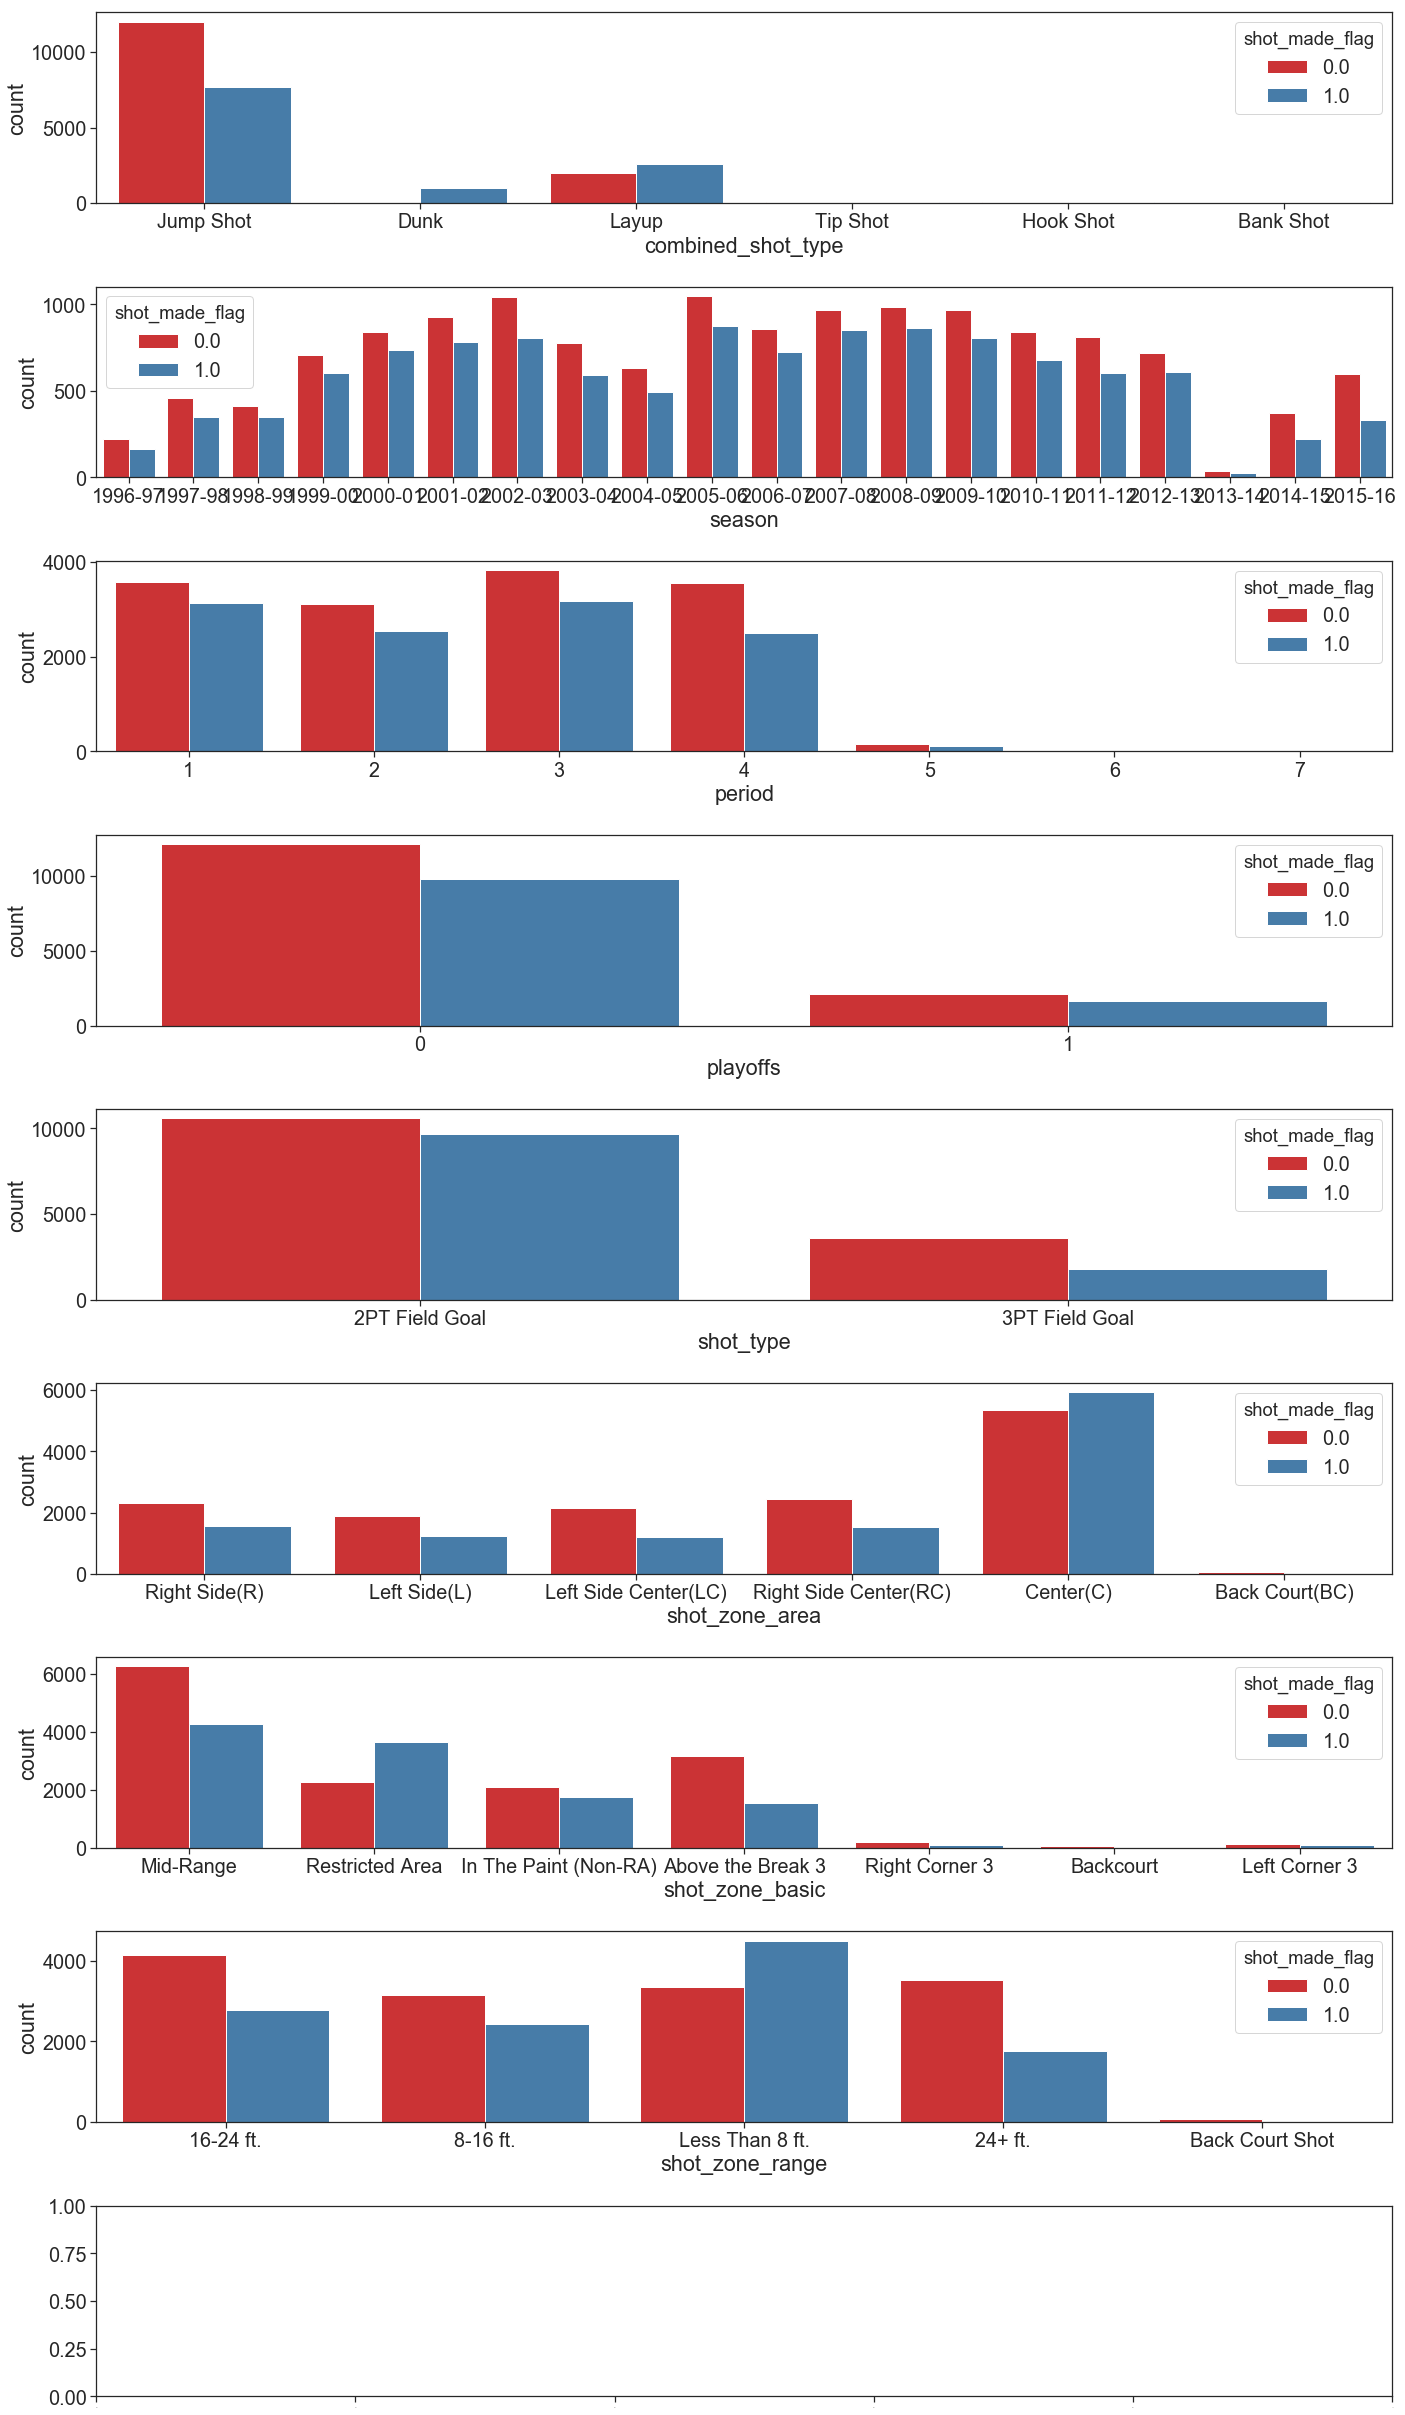

In [27]:
f, axarr = plt.subplots(9, figsize=(20, 34))
plt.xticks(fontsize=0.1)
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=kobe, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=kobe, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=kobe, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=kobe, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=kobe, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=kobe, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=kobe, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=kobe, ax=axarr[7])
plt.tight_layout()
plt.show()

从第一张“combined_shot_type”统计图可以看出，科比的投篮方式主要是跳投，干拔跳投毕竟是科比的绝技。第二张“season”统计图从侧面体现了科比完整的职业生涯：科比自1996年选秀进入NBA后，呈现迅猛的成长势头，并在1999年至2002年连续三年夺冠，建立了湖人王朝时期，但是辉煌之后的科比在2002年到2004年期间经历了短暂的低潮，在2008年到2010年两次夺冠之后，科比在2013年遭遇严重伤病，在最后三年的风平浪静之后选择了退役。

### 数据清洗

In [28]:
unknown_mask = kobe['shot_made_flag'].isnull()

我们假设各个投篮之间是相互独立的，现在我们要去掉其中的一些无关变量，如果存在相互之间强相关的自变量，我们需要删除其中的某一个变量。并将目标变量提取出来

In [29]:
kobe_cl = kobe.copy()   #创建一份拷贝
target = kobe_cl['shot_made_flag'].copy()

#去掉一些列
kobe_cl.drop('team_id',axis=1,inplace=True) #只存在一个值
kobe_cl.drop('lat',axis=1,inplace=True) #与loc_x相关
kobe_cl.drop('lon',axis=1,inplace=True) #与loc_y相关
kobe_cl.drop('game_id',axis=1,inplace=True) #与投篮命中与否明显无关
kobe_cl.drop('game_event_id',axis=1,inplace=True) #与投篮命中与否明显无关
kobe_cl.drop('team_name',axis=1,inplace=True) #只存在一个值”Los Angeles Lakers“
kobe_cl.drop('shot_made_flag',axis=1,inplace=True) #已经存为target

下面我们将定义用于异常值检测的函数，用于模型训练前去除异常值：

In [30]:
#定义异常值检测函数
def detect_outliers(series,whis=1.5):
    q75,q25 = np.percentile(series,[75,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

### 数据转换

为了模型训练方便，我们定义一些新的变量：

In [35]:
kobe_cl['matchup'].head(20)

shot_id
1       LAL @ POR
2       LAL @ POR
3       LAL @ POR
4       LAL @ POR
5       LAL @ POR
6       LAL @ POR
7       LAL @ POR
8       LAL @ POR
9       LAL @ POR
10      LAL @ POR
11      LAL @ POR
12    LAL vs. UTA
13    LAL vs. UTA
14    LAL vs. UTA
15    LAL vs. UTA
16    LAL vs. UTA
17    LAL vs. UTA
18    LAL vs. UTA
19    LAL vs. UTA
20    LAL vs. UTA
Name: matchup, dtype: object

In [32]:
kobe_cl['action_type'].head()

shot_id
1            Jump Shot
2            Jump Shot
3            Jump Shot
4            Jump Shot
5    Driving Dunk Shot
Name: action_type, dtype: object

In [36]:
#kobe_cl['matchup'].str.contains('vs').astype('int')

In [37]:
# Remaining time
kobe_cl['seconds_from_period_end'] = 60 * kobe_cl['minutes_remaining'] + kobe_cl['seconds_remaining']
kobe_cl['last_5_sec_in_period'] = kobe_cl['seconds_from_period_end'] < 5

kobe_cl.drop('minutes_remaining', axis=1, inplace=True)
kobe_cl.drop('seconds_remaining', axis=1, inplace=True)
kobe_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
kobe_cl['home_play'] = kobe_cl['matchup'].str.contains('vs').astype('int')
kobe_cl.drop('matchup', axis=1, inplace=True)

# Game date
kobe_cl['game_date'] = pd.to_datetime(kobe_cl['game_date'])
kobe_cl['game_year'] = kobe_cl['game_date'].dt.year
kobe_cl['game_month'] = kobe_cl['game_date'].dt.month
kobe_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
kobe_cl['loc_x'] = pd.cut(kobe_cl['loc_x'], 25)
kobe_cl['loc_y'] = pd.cut(kobe_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = kobe_cl['action_type'].value_counts().sort_values().index.values[:20]
kobe_cl.loc[kobe_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

由于变量中存在较多名义型变量，我们对变量进行编码：

In [39]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent','loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(kobe_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    kobe_cl.drop(cc, axis=1, inplace=True)
    kobe_cl = kobe_cl.join(dummies)

## 3.特征选择
在这一部分，我们将从编码后的多个变量中进行特征选择过程。

在sklearn中存在feture_selection模块，其中有许多种特征选择相关方法，如VarianceThreshold, RFE, SelectKBest, chi2，也可以利用随机森林模型判别变量的重要程度。

首先，我们将存在shot_made_flag值的变量提取出来用于模型训练，shot_made_flag缺失的用验证模型：

In [40]:
# 划分测试集
kobe_submit = kobe_cl[unknown_mask]

# 划分训练集
X = kobe_cl[~unknown_mask]
Y = target[~unknown_mask]

方差阈值

我们可以找出方差大于的0.09的变量，作为我们建模的变量：

In [41]:
threshold = 0.90
vt = VarianceThreshold().fit(X)
# 列出特征名
feat_var_threshold = kobe_cl.columns[vt.variances_ > threshold * (1-threshold)]
list(feat_var_threshold)

['playoffs',
 'shot_distance',
 'home_play',
 'action_type#Jump Shot',
 'combined_shot_type#Jump Shot',
 'combined_shot_type#Layup',
 'period#1',
 'period#2',
 'period#3',
 'period#4',
 'shot_type#2PT Field Goal',
 'shot_type#3PT Field Goal',
 'shot_zone_area#Center(C)',
 'shot_zone_area#Left Side Center(LC)',
 'shot_zone_area#Left Side(L)',
 'shot_zone_area#Right Side Center(RC)',
 'shot_zone_area#Right Side(R)',
 'shot_zone_basic#Above the Break 3',
 'shot_zone_basic#In The Paint (Non-RA)',
 'shot_zone_basic#Mid-Range',
 'shot_zone_basic#Restricted Area',
 'shot_zone_range#16-24 ft.',
 'shot_zone_range#24+ ft.',
 'shot_zone_range#8-16 ft.',
 'shot_zone_range#Less Than 8 ft.',
 'game_month#1',
 'game_month#2',
 'game_month#3',
 'game_month#4',
 'game_month#11',
 'game_month#12',
 'loc_x#(-10.96, 8.96]',
 'loc_y#(-10.6, 22.8]',
 'loc_y#(22.8, 56.2]',
 'loc_y#(123.0, 156.4]']

### 利用随机森林选出最重要的特征-Top 20

我们还可以通过随机森林找到最重要的20个变量：

In [43]:
model = RandomForestClassifier()
model.fit(X, Y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_rf_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
list(feat_rf_20)

['shot_distance',
 'action_type#Jump Shot',
 'home_play',
 'action_type#Layup Shot',
 'period#1',
 'period#2',
 'period#3',
 'period#4',
 'game_month#3',
 'game_month#1',
 'game_month#2',
 'game_month#4',
 'game_month#12',
 'game_month#11',
 'loc_x#(-10.96, 8.96]',
 'playoffs',
 'loc_y#(-10.6, 22.8]',
 'opponent#SAS',
 'opponent#SAC',
 'opponent#POR']

可以看到，投篮命中与否主要是跟投篮距离有关，并且与是否是跳投也很有关系，看来科比的跳投干拔不是浪得虚名。

### 利用 χ2 检验进行单变量的特征选择-Top 20

In [45]:
#首先对变量进行0-1标准化
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })
feat_chi2_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
list(feat_chi2_20)

['combined_shot_type#Dunk',
 'action_type#Jump Shot',
 'shot_zone_basic#Restricted Area',
 'loc_x#(-10.96, 8.96]',
 'action_type#Driving Layup Shot',
 'shot_zone_range#Less Than 8 ft.',
 'loc_y#(-10.6, 22.8]',
 'action_type#Slam Dunk Shot',
 'shot_type#3PT Field Goal',
 'action_type#Driving Dunk Shot',
 'shot_zone_area#Center(C)',
 'action_type#Running Jump Shot',
 'shot_zone_range#24+ ft.',
 'shot_zone_basic#Above the Break 3',
 'combined_shot_type#Layup',
 'combined_shot_type#Jump Shot',
 'last_5_sec_in_period',
 'action_type#Jump Bank Shot',
 'action_type#Pullup Jump shot',
 'shot_zone_area#Left Side Center(LC)']

容易看出 χ2 检验得到的变量重要程度排序与随机森林得到的重要程度排序不同，下面我们再试试RFE方法。

### 利用RFE方法选择特征-Top 20

RFE叫做递归特征排除法，是Recursive Feature Elimination的简写，也是一种常用的特征选择方法。

In [47]:
rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, Y)
feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })
feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
list(feat_rfe_20)

['action_type#Driving Dunk Shot',
 'action_type#Driving Finger Roll Layup Shot',
 'action_type#Driving Finger Roll Shot',
 'action_type#Driving Slam Dunk Shot',
 'action_type#Dunk Shot',
 'action_type#Fadeaway Bank shot',
 'action_type#Finger Roll Shot',
 'action_type#Hook Shot',
 'action_type#Jump Shot',
 'action_type#Layup Shot',
 'action_type#Running Bank shot',
 'action_type#Running Hook Shot',
 'action_type#Slam Dunk Shot',
 'combined_shot_type#Dunk',
 'combined_shot_type#Tip Shot',
 'shot_zone_area#Back Court(BC)',
 'shot_zone_range#Back Court Shot',
 'loc_y#(290.0, 323.4]',
 'loc_y#(356.8, 390.2]',
 'loc_y#(390.2, 423.6]']

我们将以上三种方式得到的Top 20小结一下：

In [48]:
feature_scoring = pd.DataFrame({
        'feat_rf_20': feat_rf_20,
        'feat_chi2_20': feat_chi2_20,
        'feat_rfe_20': feat_rfe_20
    })
feature_scoring

,feat_rf_20,feat_chi2_20,feat_rfe_20
0,shot_distance,combined_shot_type#Dunk,action_type#Driving Dunk Shot
1,action_type#Jump Shot,action_type#Jump Shot,action_type#Driving Finger Roll Layup Shot
2,home_play,shot_zone_basic#Restricted Area,action_type#Driving Finger Roll Shot
3,action_type#Layup Shot,"loc_x#(-10.96, 8.96]",action_type#Driving Slam Dunk Shot
4,period#1,action_type#Driving Layup Shot,action_type#Dunk Shot
5,period#2,shot_zone_range#Less Than 8 ft.,action_type#Fadeaway Bank shot
6,period#3,"loc_y#(-10.6, 22.8]",action_type#Finger Roll Shot
7,period#4,action_type#Slam Dunk Shot,action_type#Hook Shot
8,game_month#3,shot_type#3PT Field Goal,action_type#Jump Shot
9,game_month#1,action_type#Driving Dunk Shot,action_type#Layup Shot


我们将以上四种方式联合起来进行特征选择：

In [49]:
features = np.hstack([
        feat_var_threshold, 
        feat_rf_20,
        feat_chi2_20,
        feat_rfe_20
    ])
features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("-{}".format(f))

Final features set:

-action_type#Driving Dunk Shot
-action_type#Driving Finger Roll Layup Shot
-action_type#Driving Finger Roll Shot
-action_type#Driving Layup Shot
-action_type#Driving Slam Dunk Shot
-action_type#Dunk Shot
-action_type#Fadeaway Bank shot
-action_type#Finger Roll Shot
-action_type#Hook Shot
-action_type#Jump Bank Shot
-action_type#Jump Shot
-action_type#Layup Shot
-action_type#Pullup Jump shot
-action_type#Running Bank shot
-action_type#Running Hook Shot
-action_type#Running Jump Shot
-action_type#Slam Dunk Shot
-combined_shot_type#Dunk
-combined_shot_type#Jump Shot
-combined_shot_type#Layup
-combined_shot_type#Tip Shot
-game_month#1
-game_month#11
-game_month#12
-game_month#2
-game_month#3
-game_month#4
-home_play
-last_5_sec_in_period
-loc_x#(-10.96, 8.96]
-loc_y#(-10.6, 22.8]
-loc_y#(123.0, 156.4]
-loc_y#(22.8, 56.2]
-loc_y#(290.0, 323.4]
-loc_y#(356.8, 390.2]
-loc_y#(390.2, 423.6]
-opponent#POR
-opponent#SAC
-opponent#SAS
-period#1
-period#2
-period#3
-period#4
-p

## 4.PCA降维

根据第三部分特征选择得到的变量重新整理数据框训练集kobe_cl和测试集kobe_submit：

In [51]:
kobe_cl = kobe_cl.loc[:, features]
kobe_submit = kobe_submit.loc[:, features]
X = X.loc[:, features]

print('完整数据集shape: {}'.format(kobe_cl.shape))
print('测试集shape: {}'.format(kobe_submit.shape))
print('训练集shape: {}'.format(X.shape))
print('目标标签shape: {}'.format(Y.shape))

完整数据集shape: (30697, 62)
测试集shape: (5000, 62)
训练集shape: (25697, 62)
目标标签shape: (25697,)


62个变量过多，我们需要在模型训练前进行降维,使得维度减为8：

In [52]:
components = 8
pca = PCA(n_components = components).fit(X)

我们来看一下每个变量对目标变量方差的解释程度：

Text(0.5,1,'PCA - Variance explained')

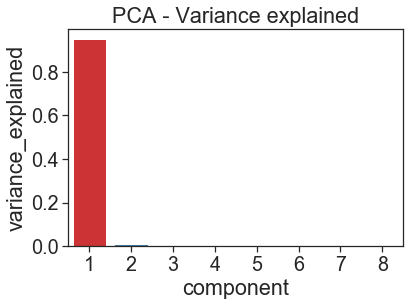

In [53]:
pca_variance_explained_df = pd.DataFrame({
    "component": np.arange(1, components+1),
    "variance_explained": pca.explained_variance_ratio_            
    })
ax = sns.barplot(x='component', 
                 y='variance_explained', 
                 data=pca_variance_explained_df,
                 palette="Set1", )
ax.set_title("PCA - Variance explained")

我们只取前两个主成分，命名为x1和x2，并在二维特征空间中画出散点图：

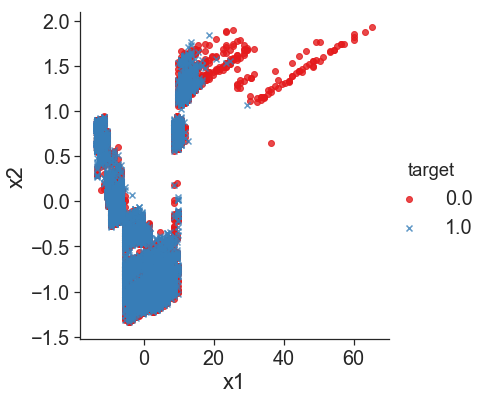

In [55]:
X_pca = pd.DataFrame(pca.transform(X)[:,:2])
X_pca['target'] = Y.values
X_pca.columns = ["x1", "x2", "target"]
sns.lmplot('x1','x2', 
           data=X_pca, 
           hue="target", 
           fit_reg=False, 
           markers=["o", "x"], 
           palette="Set1", 
           height=6,
          )

可以看出主成分x1对target的影响，在 [−70,−20] 范围内几乎全为投失的情况，在 [−20,20] 部分为投中，部分为投失，而x2对投球的决定作用要比x1小非常多。

## 5.AdaBoost模型训练

### 模型训练初探

初始化我们之后训练模型需要用到的参数：

In [59]:
seed = 7
processors=1
num_folds=3           #三折交叉验证
num_instances=len(X)
scoring='roc_auc'     #交叉验证的分数为AUC
#kfold = KFold(n_splits=num_instances, n_folds=num_folds, random_state=seed)  返回是错误的，该方法已不适用

首先使用n_estimators=100,random_state=7来看看模型的训练结果：

In [58]:
model = AdaBoostClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, Y, cv=3, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.697) +/- (0.004)


为了显示出AdaBoost的优势，我们使用其他常用的分类模型与AdaBoost做一下比较：

In [60]:
# 模型包括逻辑回归、线性判别分析、K近邻、决策树和朴素贝叶斯
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# 对每个模型计算其cross_cal_score
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=3, scoring='roc_auc', n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (0.694) +/- (0.003)


D:\Apps\PythonicApps\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Apps\PythonicApps\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Apps\PythonicApps\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: (0.694) +/- (0.003)
K-NN: (0.616) +/- (0.012)
CART: (0.591) +/- (0.010)
NB: (0.660) +/- (0.006)


从结果中可以看出，逻辑回归和线性判别分析方法在训练集中有更好的表现,比AdaBoost略微逊色。

### 模型调参：单个参数
下面，我们来看看不同的参数会对模型的训练产生什么影响：

### (1) 参数“n_estimators”

In [61]:
n_estimators, scores = list(range(1,100,10)), []
for i in n_estimators:
    model = AdaBoostClassifier(n_estimators = i, learning_rate = 1, random_state = seed)
    cv_results = cross_val_score(model, X, Y, cv=3, scoring=scoring, n_jobs=processors)
    scores.append(cv_results)
cv_results = [i for i in n_estimators for j in range(num_folds)]

绘制盒图，横坐标为n_estimators，纵坐标为AUC：

Text(0,0.5,'AUC')

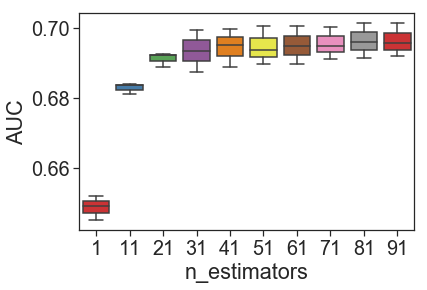

In [62]:
ax = plt.axes()
sns.boxplot(x = cv_results, 
            y = np.array(scores).flatten(),
            palette='Set1',
            ax=ax)
ax.set_xlabel('n_estimators')
ax.set_ylabel('AUC')

当n_estimators小于41时，随着n_estimators增加AUC也逐渐增加，但是到了31之后，AUC变化不显著，因此n_estimators默认的50是较好的数值。

### (2) 参数“learning_rate”

在上面一部分，我们得出最佳的n_estimators为50，在此基础上，我们再对learning_rate进行调节：

In [63]:
learning_rate, scores = list(range(1,10,1)), []
for i in learning_rate:
    model = AdaBoostClassifier(n_estimators = 50, learning_rate = i, random_state = seed)
    cv_results = cross_val_score(model, X, Y, cv=3, scoring=scoring, n_jobs=processors)
    scores.append(cv_results)
cv_results = [i for i in learning_rate for j in range(num_folds)]

Text(0,0.5,'AUC')

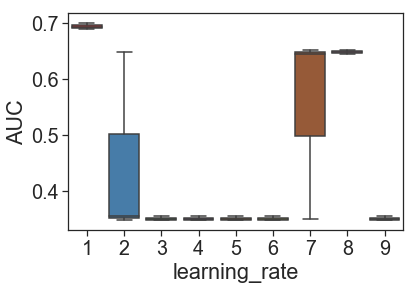

In [64]:
ax = plt.axes()
sns.boxplot(x = cv_results, 
            y = np.array(scores).flatten(),
            palette='Set1',
            ax=ax)
ax.set_xlabel('learning_rate')
ax.set_ylabel('AUC')

从图可以得出结论：learning_rate在取1时，模型效果更好。

### (3) 参数“random_state”

同样的道理，现在再对random_state做一个分析：

In [65]:
random_state, scores = list(range(1,100,10)), []
for i in random_state:
    model = AdaBoostClassifier(n_estimators = 50, learning_rate = 1, random_state = i)
    cv_results = cross_val_score(model, X, Y, cv=3, scoring=scoring, n_jobs=processors)
    scores.append(cv_results)
cv_results = [i for i in random_state for j in range(num_folds)]

Text(0,0.5,'AUC')

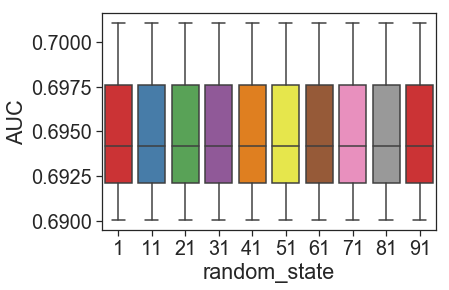

In [66]:
ax = plt.axes()
sns.boxplot(x = cv_results, 
            y = np.array(scores).flatten(),
            palette='Set1',
            ax=ax)
ax.set_xlabel('random_state')
ax.set_ylabel('AUC')

似乎randome_state对模型没什么影响。

### 模型调参：多个参数同时调节

sklearn中有GridSearchCV方法，可以对多个参数同时进行调节,如下：

In [68]:
ada_grid = GridSearchCV(
    estimator = AdaBoostClassifier(random_state=seed),
    param_grid = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': list(range(1,100,10)),
        'learning_rate': [1e-3, 1e-2, 1e-1, 1]
    }, 
    cv = 3, 
    scoring = scoring, 
    n_jobs = processors)
ada_grid.fit(X, Y)
print(ada_grid.best_score_)
print(ada_grid.best_params_)

0.6963847080113316
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 81}


GridSearchCV方法与单个参数调节得到的参数大致一样。

## 6.模型预测

我们最后使用AdaBoost算法得到的模型，对数据集中的测试集进行预测。在Kaggle竞赛中，该测试集并没有包含shot_made_flag，即没有目标变量值。因此，我们并不能判断此模型的泛化性能。不过，我们还是把预测的结果展示一部分在这里：

In [69]:
model.fit(X,Y)
probs = model.predict_proba(kobe_submit)
preds = model.predict(kobe_submit)
submission = pd.DataFrame({
        'shot_id':kobe_submit.index,
        'shot_made_flag':preds,
        'shot_made_flag_probability':probs[:,0]
    })
submission.head(5)

,shot_id,shot_made_flag,shot_made_flag_probability
0,1,0.0,0.503029
1,8,0.0,0.504593
2,17,1.0,0.497461
3,20,1.0,0.494364
4,33,0.0,0.503525
